<a href="https://colab.research.google.com/github/dmswl0707/ResNet_Pytorch/blob/main/Train_test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch

In [ ]:
### Data_loader
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data',train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)


In [ ]:
### 이미지 확인

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
def conv_block_1(in_channel, out_channel, act_fn, stride = 1):
    model = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size = 1, stride = stride),
        act_fn
    )
    return model

def conv_block_3(in_channel, out_channel, act_fn, stride = 1):
    model = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size = 3, stride = stride, padding = 1),
        act_fn
    )
    return model

In [ ]:
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channel, mid_channel, out_channel, act_fn, dowm = False):
        super(ResidualBlock, self).__init__()
        self.act_fn = act_fn
        self.down = down #featur map이 줄어드는지 안 줄어드는지

        if self.down: #BottleNeck
            self.layer = nn.Sequential(
                conv_block_1(in_channel, mid_channel, act_fn, stride = 2),
                conv_block_3(mid_channel, mid_channel, act_fn),
                conv_block_1(mid_channel, out_channel, act_fn)
            )
            self.downsample = nn.Conv2d(in_channel, out_channel, kernel_size = 1, stride = 2)
        else:
            self.layer = nn.Sequential(
                conv_block_1(in_channel, mid_channel, act_fn, stride = 2),
                conv_block_3(mid_channel, mid_channel, act_fn),
                conv_block_1(mid_channel, out_channel, act_fn)
            )
            self.dim_equalizer = nn.Conv2d(in_channel, out_channel, kernel_size = 1)

    def forward(self, x):
        if self.down:
            downsample = self.downsample(x)
            out = self.layer(x)
            out = out + downsample
        else: 
            out = self.layer(x)
            if x.size() is not out.size():
                x = self.dim_equalizer(x)
            out = out + x
        return out


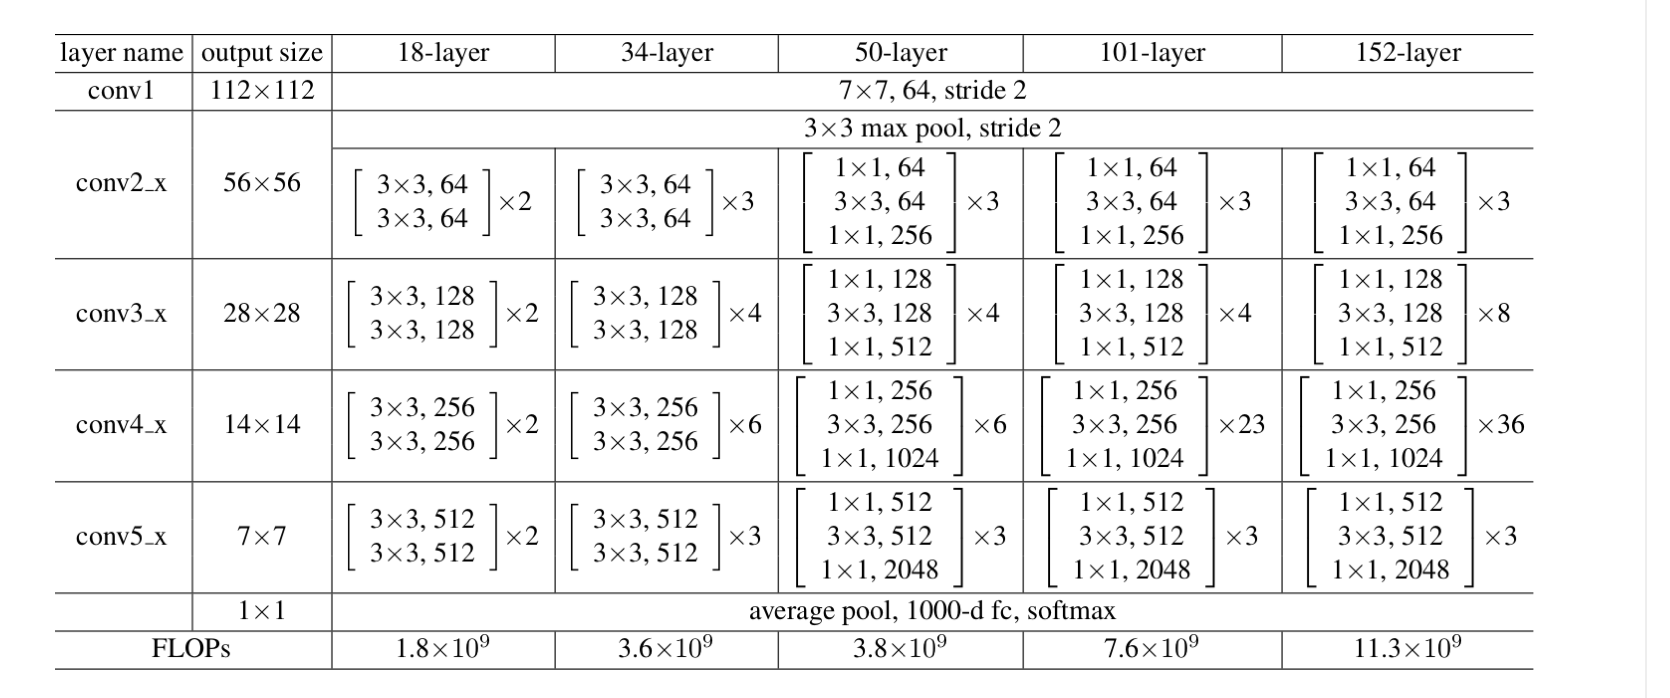

In [ ]:
### model(ResNet)

class Model(nn.Module):
    def __init__(self, num_class):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, 2, 3)
        self.BN = nn.BatchNorm2d(64)
        self.Act = nn.ReLU(inplace = True)
        self.pool = nn.MaxPool2d(3, 2, 1) 

        self.module1 = nn.Sequential(
            ResidualBlock(),
            ResidualBlock(),
            ResidualBlock()
            )
        self.module2 = nn.Sequential(
            ResidualBlock(),
            ResidualBlock(),
            ResidualBlock(),
            ResidualBlock()
            )
        self.module3 = nn.Sequential(
            ResidualBlock(),
            ResidualBlock(),
            ResidualBlock(),
            ResidualBlock(),
            ResidualBlock(),
            ResidualBlock()
            )
        self.module4 = nn.Sequential(
            ResidualBlock(),
            ResidualBlock(),
            ResidualBlock()
            )


     
        self.fc = nn.Linear(2048, 10)
        self.avgpool = nn.AvgPool2d((2, 2), stride = 0)

    def forward(self, input):
        x = input
        x = self.conv(x)
        x = self.BN(x)
        x = self.Act(x)
        x = self.pool(x)
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.avgpool(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x









In [ ]:
# 손실 함수, optimizer 정의

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ResNet.parameters(), lr = 0.001, momentun = 0.9)

In [ ]:
# training

for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = ResNet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss : %.3f' % 
                  (epoch+1, i+1, running_loss/2000)) 
            running_loss = 0.0

In [ ]:
# 학습한 모델 저장

PATH = './cifar_net.pth'
torch.save(ResNet.state_dict(), PATH)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))